# Question 2: Classifying wines as red and white

In this section we will attempt to build, train and test 4 different models for classifying wines as either red or white. We will also take a look at how normalizing our data affects the performance of each of these models. The four models we will look at are:
- Logistic Regression (using `liblinear` solver)
- K neighbours (using `KNeighborsClassifier`)
- Linear SVM (using `svm.SVC` with `kernel=linear`)
- Combined Model of the above (using `votingClassifier`)
After comparing the performance of these models with the original and normalized data, we will perform dimension reduction with `pca` and re-evaluate the models.
By the end of our analysis we will be able to answer which model is best suited for the original, normalized and reduced dimension data. 

## Importing and reading data from svc

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
white_path = "wine-white.csv"
red_path = "wine-red.csv"

def import_merge_df(file_name1, file_name2):
    #white wines
    df1 = pd.read_csv(file_name1)
    df1['type']='white'
    #red wines
    df2 = pd.read_csv(file_name2)
    df2['type']='red'
    print(df1.shape)
    print(df2.shape)
    # merge the dataframes 
    df = pd.concat([df1, df2], ignore_index=True)
    return df


df = import_merge_df(red_path, white_path)
df

(1599, 13)
(4898, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,white
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,white
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,white
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,white
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,red
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,red
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,red
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,red


## Splitting data into features and labels

The 'type' of the wine is the label in this question, and the rest are the features.

In [57]:
features = df.drop('type',1)
labels = df['type']

print(features.shape, labels.shape) 

(6497, 12) (6497,)


## Finding best KNN 

Before we compare different models we need to narrow down which number of neighbours for `KNN` yields the highest train and test score. We will look at the weighted train test accuracies for all odd `k`'s in the range of `k` = 1 to `k` = 25.



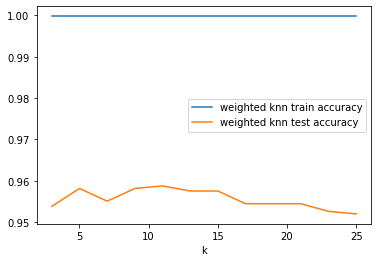

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

#Fixed seed for all different Ks
seed = 5026
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=seed)

def test_knn(k_range, X_train, X_test, y_train, y_test, **knn_params):
#     knn_tmp = pd.DataFrame()
    knn_list = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k,**knn_params)
        knn.fit(X_train, y_train)
        knn_score_train = knn.score(X_train, y_train)
        knn_score_test = knn.score(X_test, y_test)
        
        values = (k,knn_score_train,knn_score_test)
        knn_list.append(values)
    
    
    knn_tmp = pd.DataFrame(knn_list, columns =['k', 'train_score', 'test_score']).set_index('k')
    return knn_tmp


weights={'weights':'distance'}
knn_score_weighted = test_knn(range(3,26,2), x_train, x_test, y_train, y_test, **weights)

ax = knn_score_weighted.plot()
ax.legend(["weighted knn train accuracy", "weighted knn test accuracy","lr score"]);

In [59]:
bestK = knn_score_weighted['test_score'].idxmax()
print(bestK)

11


As we can see from above the `k` with the highest test accuracy is `k` = 11. We can now compare different models to find the model best fitted for predicted the type of wine.

## Finding the best classifiers 

To accurately compare the performance of different models the models need to be trained and tested on the same data sets, we will achieve this by using a fixed random seed. We will loop over 30 seeds to get an average score for each of the models. 

The different models we are testing are 
- Logistic Regression (using `liblinear` solver)
- K neighbours (using `KNeighborsClassifier`)
- Linear SVM (using `svm.SVC` with `kernel=linear`)

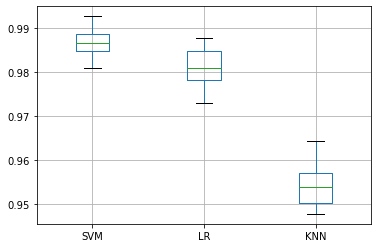

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

scores = {name: [] for name in ('SVM', 'LR', 'KNN')}

for seed in range(5000,5031):
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=seed)
   
    lsvc = svm.SVC(kernel='linear').fit(x_train, y_train)
    logisticRegr = LogisticRegression(max_iter=10000,solver = 'liblinear').fit(x_train, y_train)
    knn = KNeighborsClassifier(n_neighbors=bestK,**weights).fit(x_train, y_train)

    
    scores['SVM'].append(lsvc.score(x_test,y_test))
    scores['LR'].append(logisticRegr.score(x_test,y_test))
    scores['KNN'].append(knn.score(x_test,y_test))
    

df = pd.DataFrame(scores)
df.boxplot()

From the results above the linear svm model seems to yeild the highest test prediction accuracy. However, this may not be the best approach, another way to increase the accuracy is the train multiple models and use an ensemble of them for predictions. 

## Combined Ensemble Model

In this section we will train  `linear svm`, `logistic regression` and `kneighbours` models and create a combined model of the three. The combined model will use a voting classifier to decide between the three models.

In [61]:
from sklearn.ensemble import VotingClassifier

#create and return trained models
def create_models(x_train, y_train, k):
    models = []
    
    weights={'weights':'distance'}
    lsvc = svm.SVC(kernel='linear').fit(x_train, y_train)
    logisticRegr = LogisticRegression(max_iter=10000,solver = 'liblinear').fit(x_train, y_train)
    knn = KNeighborsClassifier(n_neighbors=k,**weights).fit(x_train, y_train)
    
    models.append(lsvc)
    models.append(logisticRegr)
    models.append(knn)
    
    return models

models = create_models(x_train, y_train, bestK)

In [62]:
from scipy.stats import mode

#function used to predict for combined model
def predict(models, X):
    predictions = []
    for model in models:
        predictions.append(model.predict(X))
        result = mode(predictions)[0][0]
    return result

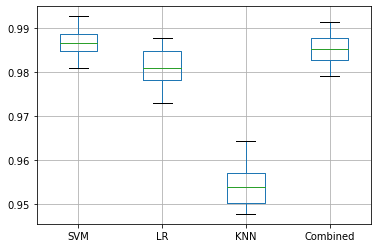

In [63]:
from sklearn.metrics import accuracy_score

scores = {name: [] for name in ('SVM', 'LR', 'KNN', 'Combined')}

for seed in range(5000,5031):
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=seed)
    
    model_list = create_models(x_train, y_train, bestK)
    combined_model = predict(model_list, x_test)
    
    scores['SVM'].append(model_list[0].score(x_test,y_test))
    scores['LR'].append(model_list[1].score(x_test,y_test))
    scores['KNN'].append(model_list[2].score(x_test,y_test))
    scores['Combined'].append(accuracy_score(y_test,combined_model))

df = pd.DataFrame(scores)
df.boxplot()



The graph below shows the mean scores for each of the models. Similar to the boxplot above, the `svm.SVC` model has the highest score.

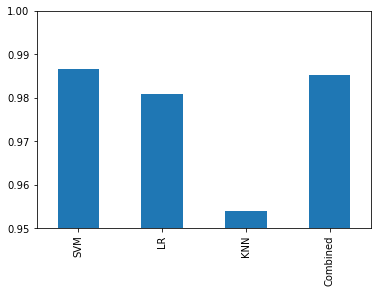

In [32]:
df.mean().plot.bar(ylim=(0.95,1.0))

We can see from above that the `svm.SVC` model remains as the model with the highest test scores, therefor this model is best suited to predict the wine type (red or white) based off of the features in our data set.

## Normalizing data 

Normalizing data can be beneficial for multiple alogorithms, particulary ones that deal with distances and magnitudes. This means that normalizing should affect our KNN and SVM model scores. Below we will repeat the steps above but with normalized data. 

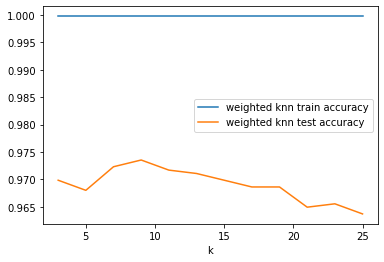

In [33]:
from sklearn.preprocessing import normalize

features_normalized = normalize(features, axis=1)

#same seed we evaluated all ks on above (without normalized data)
seed = 5026
x_train, x_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.25, random_state=seed)

weights={'weights':'distance'}
knn_score_weighted = test_knn(range(3,26,2), x_train, x_test, y_train, y_test, **weights)

ax = knn_score_weighted.plot()
ax.legend(["weighted knn train accuracy", "weighted knn test accuracy","lr score"]);

In [34]:
postNormalizationBestK = knn_score_weighted['test_score'].idxmax()
print(postNormalizationBestK)

9


After normalizing the data, the ideal number of neighbours to take into account is no longer `11`, but `9`.

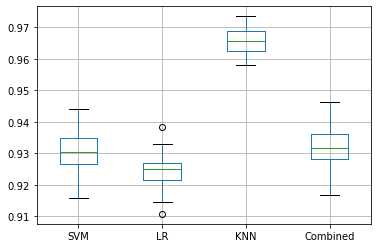

In [53]:
scores_normalized = {name: [] for name in ('SVM', 'LR', 'KNN', 'Combined')}

for seed in range(5000,5031):
    x_train, x_test, y_train, y_test = train_test_split(features_normalized, labels, test_size=0.25, random_state=seed)
    
    #pass in updated k
    model_list = create_models(x_train, y_train, postNormalizationBestK)
    combined_model = predict(model_list, x_test)
    
    scores_normalized['SVM'].append(model_list[0].score(x_test,y_test))
    scores_normalized['LR'].append(model_list[1].score(x_test,y_test))
    scores_normalized['KNN'].append(model_list[2].score(x_test,y_test))
    scores_normalized['Combined'].append(accuracy_score(y_test,combined_model))


df_normalized = pd.DataFrame(scores_normalized)
df_normalized.boxplot()


After normalizing the data, we notice that the performance of the models changes significantly. The plot below compares the normalized model performances to those we saw before normalizing.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc85b5f15b0>,
      dtype=object)

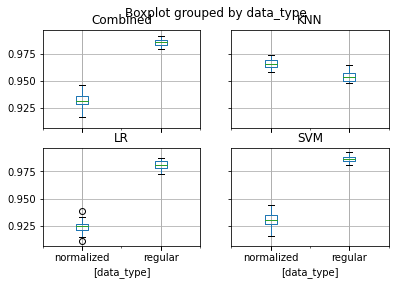

In [54]:
df_normalized['data_type'] = "normalized"

df['data_type'] = "regular"

df_merged = pd.concat([df_normalized, df], ignore_index=True)

df_merged.boxplot(by='data_type')

As we can see the only model who's performance improved after normalizing is the `KNN` model. This can be attributed to the fact that `KNN` depends on the distances between neighbours. Based off the normalized data, the `KNN` model yields the highest test score accuracy making it the best model to solve this problem. 


# Results

The best model for each case is outlined below:
- Regular Data:  Linear SVM (using `svm.SVC` with `kernel=linear`)
- Normalized Data: K neighbours (using `KNeighborsClassifier`)\
- Dimension Reduced Data: K neighbours (using `KNeighborsClassifier`)